### Continuity


> Samples are needed for sequence models and transformer models for input

😈 **Task 1:** What are some key differences between AR models and sequence models like RNNs or Transformers?

😈 **Question 1:** Why is it important to maintain time continuity when preparing samples for sequence models?



In [ ]:
import pandas as pd
import os

## Normalized data csv is also made available for the select stations in URL:
# https://drive.google.com/file/d/1Eui59GyTXNv839WijdZ0CkzuMubmZQz1/view?usp=drive_link
dataframe = pd.read_csv(r"./content/timeseries_data/normalized_data.csv")
# variable_columns = ["no2", "temp", "o3", "no", "press"]
variable_column = "temp"
dataframe.shape

(576371, 5)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

In [11]:
# Function to create continous time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, n_past=24, n_future=6):
    X, y = [], []
    data['datetime'] = pd.to_datetime(data['datetime'], utc=True)
    for i in range(n_past, len(data) - n_future):
        window = data['datetime'].iloc[i - n_past : i + n_future]
        if not (window.diff().iloc[1:] == pd.Timedelta(hours=1)).all():
            continue # only if each step is 1 hour apart

        X.append(data[variable_column].iloc[i - n_past : i].values)
        y.append(data[variable_column].iloc[i : i + n_future].values)
    return np.array(X), np.array(y)

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

80/20 train/test split chosen for illustration

😈 **Task 2:** Try a rolling-window cross-validation strategy. How does model performance vary?

😈 **Question 2:** What are the pitfalls of using random splits in timeseries forecasting?


In [17]:
## This cell could take upto 10 mins to go over 600000 time steps to generate continous samples
context_window = 336
prediction_horizon = 96 # Predict 96 steps for each variable from 24 past values
X, y = create_sequences(dataframe,context_window,prediction_horizon)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (319325, 336), y_train shape: (319325, 96)
X_test shape: (79832, 336), y_test shape: (79832, 96)


In [12]:
import pickle

with open("./content/X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("./content/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("./content/y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("./content/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("Train/test datasets saved successfully.")

Train/test datasets saved successfully.


In [ ]:
import pickle
## Processed data .pkl files are also made available for the select stations in URL:
# only temp : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=sharing

with open("./content/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("./content/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("./content/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("./content/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (319325, 336), y_train shape: (319325, 96)
X_test shape: (79832, 336), y_test shape: (79832, 96)


### Forecasting with MA models: SARIMAX


😈 **Task 4:** Try modeling without seasonal terms. How do AIC and RMSE compare?

😈 **Task 5:** Add an exogenous variable like `o3` into SARIMAX and observe results.

😈 **Question 4:** How does adding an exogenous variable enhance forecasting in SARIMAX?




Station: DEBW073 | ADF p-value: 1.360720943746767e-16


C:\Users\Sindhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sindhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sindhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start

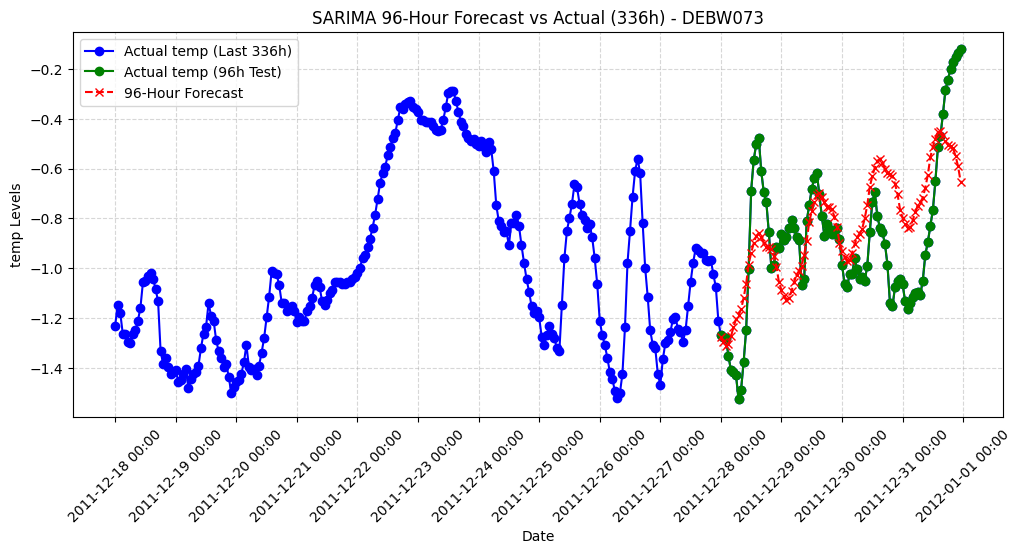

Mean Squared Error (MSE): 0.057


,SARIMA Summary
DEBW073,SARIMAX R...


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error

dataframe['datetime'] = pd.to_datetime(dataframe['datetime'])
df = dataframe.sort_values(by=['station_code', 'datetime'])

# Define forecast horizon (96 hours = 4 days)
forecast_hours = 96

sarima_results = {}

station = 'DEBW073'
station_data = df[df['station_code'] == station].copy()
station_data.set_index('datetime', inplace=True)
station_data = station_data.sort_index()

# Use only 'o3' column
o3_data = station_data['temp'].dropna()

if len(o3_data) > 50 + forecast_hours:  # To ensure sufficient data points
    train_o3_data = o3_data.iloc[:-forecast_hours]
    test_o3_data = o3_data.loc[o3_data.index >= (o3_data.index[-1] - pd.Timedelta(hours=95))]
    
    # Check stationarity using ADF test
    adf_test = adfuller(train_o3_data)
    p_value = adf_test[1]
    print(f"Station: {station} | ADF p-value: {p_value}")

    # Differencing if needed
    d = 0 if p_value < 0.05 else 1  # If p-value < 0.05, it's stationary

    # Detect seasonal frequency
    inferred_freq = pd.infer_freq(train_o3_data.index)
    if inferred_freq is not None:
        if "H" in inferred_freq:  
            seasonal_period = 24
        elif "D" in inferred_freq:  
            seasonal_period = 7
        elif "M" in inferred_freq: 
            seasonal_period = 12
        else:
            seasonal_period = 12 
    else:
        seasonal_period = 12  # Default if frequency cannot be inferred

    # Fit SARIMA model
    try:
        sarima_model = SARIMAX(train_o3_data,
            order=(1, d, 1),
            seasonal_order=(1, d, 1, seasonal_period),
            enforce_stationarity=False,
            enforce_invertibility=False).fit()

        fitted_values = sarima_model.fittedvalues
        forecast = sarima_model.get_forecast(steps=forecast_hours)
        forecast_values = forecast.predicted_mean
        confidence_intervals = forecast.conf_int()
        forecast_index = pd.date_range(start=test_o3_data.index[0], periods=forecast_hours, freq="h")
        actual_336 = o3_data.loc[o3_data.index >= (o3_data.index[-1] - pd.Timedelta(hours=335))]

        # Plot actual vs predicted values
        plt.figure(figsize=(12, 5))

        plt.plot(actual_336.index, actual_336, label="Actual temp (Last 336h)", marker='o', color='blue')
        plt.plot(test_o3_data.index, test_o3_data, label="Actual temp (96h Test)", marker='o', color='green')
        plt.plot(forecast_index, forecast_values, label="96-Hour Forecast", linestyle="dashed", marker='x', color='red')

        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=45)

        plt.title(f"SARIMA 96-Hour Forecast vs Actual (336h) - {station}")
        plt.xlabel("Date")
        plt.ylabel("temp Levels")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

        sarima_results[station] = sarima_model.summary()

        mse = mean_squared_error(test_o3_data, forecast_values)
        print(f"Mean Squared Error (MSE): {mse:.3f}")

    except Exception as e:
        sarima_results[station] = f"Error: {e}"

sarima_results_df = pd.DataFrame.from_dict(sarima_results, orient='index', columns=['SARIMA Summary'])
display(sarima_results_df)
